In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
import h3
import time

In [3]:
import sys, os, gc

sys.path.append(os.path.abspath('..'))
%load_ext autoreload
%autoreload 2
from modules.config import *

## Feature Preparation

First, we import the trip data and drop some columns that we dont need for clustering.

In [4]:
#read in trip data
trips_df = pd.read_parquet("../00_data/processed/trips_land_use.parquet")
trips_df.head(2)

,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number,trip_start,p_uid_start,p_bikes_start,lat_start,b_electric_lock,...,in_charged_flexzone_end,type,min_distance,duration,min_avg_speed,geometry_end,land_use_end,geometry_start,index_right,land_use_start
index,,,,,,,,,,,,,,,,,,,,,
1200,False,0,12,2019-01-20 20:58:00,23221,start,12118482,1,51.332653,True,...,True,trip,2.492277,17.0,8.796272,b'\x01\x01\x00\x00\x00K\x01\xc3\x90`\xabI@\xdb...,"Industrial, commercial, public, military and p...",b'\x01\x01\x00\x00\x00\n\xc9ib\x94\xaaI@\x91&8...,10,Other roads and associated land
2279,False,0,12,2019-01-21 08:42:00,23221,start,12120802,1,51.338741,True,...,False,trip,1.773600,13.0,8.185845,b'\x01\x01\x00\x00\x00\xb7\x9cKqU\xa9I@\xc6\xa...,"Industrial, commercial, public, military and p...",b'\x01\x01\x00\x00\x00\xd7\\{\xdb[\xabI@\xcb\x...,966,Continuous urban fabric (S.L. : > 80%)


In [5]:
trips = trips_df.loc[:, ['datetime_start', "b_number", 'lat_start', 'lng_start', 'datetime_end', 'lat_end', 'lng_end', 'min_distance','duration','min_avg_speed', 'land_use_start', 'land_use_end' ]]
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end
index,,,,,,,,,,,,
1200,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,Other roads and associated land,"Industrial, commercial, public, military and p..."
2279,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,Continuous urban fabric (S.L. : > 80%),"Industrial, commercial, public, military and p..."


In [6]:
del trips_df
gc.collect()

0

#### Land use data
We also transform the land use types to categorical values.

In [7]:
#change land use to categorical
import json
with open('../00_data/processed/land_use_dict.json') as json_file:
    land_use_dict = json.load(json_file)

trips.land_use_start = trips.land_use_start.map(land_use_dict)
trips.land_use_end = trips.land_use_end.map(land_use_dict)
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end
index,,,,,,,,,,,,
1200,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,20,2
2279,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,3,2


#### Weather data
We merge some weather data onto the trips.

In [8]:
#round start time to hourly to merge weather data
trips["start_time_floored"] = trips["datetime_start"].dt.floor("H")
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,start_time_floored
index,,,,,,,,,,,,,
1200,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,20,2,2019-01-20 20:00:00
2279,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,3,2,2019-01-21 08:00:00


In [9]:
#get weather data 
weather = pd.read_parquet("../00_data/repo_data/weather_aggr.parquet")
weather = weather[weather["time_interval_length"]==1]
weather

,min_temperature,max_temperature,mean_temperature,mean_mean_wind_speed,mean_total_cloud_cover,sum_precipitation,time_interval_length
MESS_DATUM,,,,,,,
2019-01-01 00:00:00,7.4,7.4,7.4,2.8,8.0,0.0,1
2019-01-01 01:00:00,7.7,7.7,7.7,2.9,8.0,0.0,1
2019-01-01 02:00:00,7.7,7.7,7.7,3.7,8.0,0.0,1
2019-01-01 03:00:00,7.7,7.7,7.7,3.2,8.0,0.0,1
2019-01-01 04:00:00,7.6,7.6,7.6,3.3,8.0,0.0,1
...,...,...,...,...,...,...,...
2019-12-31 19:00:00,2.8,2.8,2.8,2.3,1.0,0.0,1
2019-12-31 20:00:00,2.4,2.4,2.4,2.0,5.0,0.0,1
2019-12-31 21:00:00,2.7,2.7,2.7,2.3,7.0,0.0,1


In [10]:
trips = trips.merge(weather, left_on="start_time_floored", right_on="MESS_DATUM", how="left", right_index=False)
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,start_time_floored,min_temperature,max_temperature,mean_temperature,mean_mean_wind_speed,mean_total_cloud_cover,sum_precipitation,time_interval_length
0,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,20,2,2019-01-20 20:00:00,-6.4,-6.4,-6.4,0.6,1.0,0.0,1
1,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,3,2,2019-01-21 08:00:00,-7.0,-7.0,-7.0,0.6,8.0,0.0,1


In [11]:
del weather
gc.collect()

20

#### Temporal features
Additionally, we create temporal features from the datetime objects.

In [12]:
#create time features
trips['hour'] = trips.start_time_floored.dt.hour
trips['weekday'] = trips.start_time_floored.dt.weekday
trips['month'] = trips.start_time_floored.dt.month
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,...,min_temperature,max_temperature,mean_temperature,mean_mean_wind_speed,mean_total_cloud_cover,sum_precipitation,time_interval_length,hour,weekday,month
0,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,...,-6.4,-6.4,-6.4,0.6,1.0,0.0,1,20,6,1
1,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,...,-7.0,-7.0,-7.0,0.6,8.0,0.0,1,8,0,1


#### POIs

We also add POI features.

In [13]:
#get hexagon ids from trip locations
trips["hexagon_id_start"] = trips.apply(lambda loc: h3.geo_to_h3(lat=loc["lat_start"], lng=loc["lng_start"], resolution=9), axis=1)
trips["hexagon_id_end"] = trips.apply(lambda loc: h3.geo_to_h3(lat=loc["lat_end"], lng=loc["lng_end"], resolution=9), axis=1)
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,...,mean_temperature,mean_mean_wind_speed,mean_total_cloud_cover,sum_precipitation,time_interval_length,hour,weekday,month,hexagon_id_start,hexagon_id_end
0,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,...,-6.4,0.6,1.0,0.0,1,20,6,1,891f1a16487ffff,891f1a8ca53ffff
1,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,...,-7.0,0.6,8.0,0.0,1,8,0,1,891f1a8ca53ffff,891f1a8d93bffff


In [14]:
#read in poi data
hexagon_pois = pd.read_parquet(HEXAGON_WITH_POIS_PATH)
hexagon_pois = hexagon_pois[hexagon_pois["h3_res"]==9]
hexagon_pois.drop(columns=["h3_res", "hex_and_neighbors"], inplace=True)
hexagon_pois.head(2)

,hex,sustenance_poi,public_transport_poi,education_poi,arts_and_culture_poi,sports_poi
798,891f1a10d13ffff,0,3,0,0,0
799,891f1a10d8fffff,0,3,0,0,0


In [15]:
#merge hexagon pois with trip start
trips = trips.merge(hexagon_pois, left_on="hexagon_id_start", right_on="hex", how="left",right_index=False)
trips.rename(columns={"sustenance_poi": "sustenance_poi_start", 
                    "public_transport_poi": "public_transport_poi_start", 
                    "education_poi": "education_poi_start",
                    "arts_and_culture_poi": "arts_and_culture_poi_start",
                    "sports_poi": "sports_poi_start",
                    }, inplace=True)
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,...,weekday,month,hexagon_id_start,hexagon_id_end,hex,sustenance_poi_start,public_transport_poi_start,education_poi_start,arts_and_culture_poi_start,sports_poi_start
0,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,...,6,1,891f1a16487ffff,891f1a8ca53ffff,891f1a16487ffff,13.0,12.0,8.0,0.0,1.0
1,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,...,0,1,891f1a8ca53ffff,891f1a8d93bffff,891f1a8ca53ffff,39.0,13.0,4.0,2.0,2.0


In [16]:
#merge hexagon pois with trip end
trips = trips.merge(hexagon_pois, left_on="hexagon_id_end", right_on="hex", how="left",right_index=False)
trips.rename(columns={"sustenance_poi": "sustenance_poi_end", 
                    "public_transport_poi": "public_transport_poi_end", 
                    "education_poi": "education_poi_end",
                    "arts_and_culture_poi": "arts_and_culture_poi_end",
                    "sports_poi": "sports_poi_end",
                    }, inplace=True)
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,...,public_transport_poi_start,education_poi_start,arts_and_culture_poi_start,sports_poi_start,hex_y,sustenance_poi_end,public_transport_poi_end,education_poi_end,arts_and_culture_poi_end,sports_poi_end
0,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,...,12.0,8.0,0.0,1.0,891f1a8ca53ffff,39.0,13.0,4.0,2.0,2.0
1,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,...,13.0,4.0,2.0,2.0,891f1a8d93bffff,25.0,18.0,3.0,1.0,4.0


In [17]:
#drop unnecessary columns
trips.drop(columns=["time_interval_length", "hex_x", "hex_y"], inplace=True)

In [18]:
del hexagon_pois
gc.collect()

0

## Feature Selection

Now that we have merged all relevant data sets, we can take a look at which columns we can drop. In order to keep the feature space interpretable we limit the clustering to the following feature groups:
- Location: 'lat_start', 'lng_start','lat_end', 'lng_end'
- Temporal: 'hour','#weekday', 'month'
- Weather: 'mean_temperature', 'mean_mean_wind_speed', 'mean_total_cloud_cover', 'sum_precipitation'
- POI: 'sustenance_poi_start', 'public_transport_poi_start',
 'education_poi_start', 'arts_and_culture_poi_start', 'sports_poi_start',
 'sustenance_poi_end', 'public_transport_poi_end', 'education_poi_end',
 'arts_and_culture_poi_end', 'sports_poi_end'
- Land use: 'land_use_start_0',
 'land_use_start_1', 'land_use_start_2', 'land_use_start_4',
 'land_use_start_5', 'land_use_start_8', 'land_use_start_9',
 'land_use_start_11', 'land_use_start_12', 'land_use_start_20',
 'land_use_end_0', 'land_use_end_1', 'land_use_end_2', 'land_use_end_4',
 'land_use_end_5', 'land_use_end_8', 'land_use_end_9', 'land_use_end_11',
 'land_use_end_12', 'land_use_end_20

In [20]:
trips = trips.drop(columns=["start_time_floored", "datetime_start", "datetime_end", 'hexagon_id_start', 'hexagon_id_end', 'b_number'])
trips.head(2)

,lat_start,lng_start,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,min_temperature,...,sustenance_poi_start,public_transport_poi_start,education_poi_start,arts_and_culture_poi_start,sports_poi_start,sustenance_poi_end,public_transport_poi_end,education_poi_end,arts_and_culture_poi_end,sports_poi_end
0,51.332653,12.367146,51.338884,12.332661,2.492277,17.0,8.796272,20,2,-6.4,...,13.0,12.0,8.0,0.0,1.0,39.0,13.0,4.0,2.0,2.0
1,51.338741,12.332891,51.322920,12.336262,1.773600,13.0,8.185845,3,2,-7.0,...,39.0,13.0,4.0,2.0,2.0,25.0,18.0,3.0,1.0,4.0


We reduce the land use variable to only contain the 9 most occuring land use types and merge all others into group 0.

In [21]:
#shorten land_use for land_use_start
trips.land_use_start = trips.land_use_start.replace([3,6], 1)
trips.land_use_start = trips.land_use_start.replace([7,14,18,21,10,13,15,16,19], 0)
trips["land_use_start"].value_counts()

1     237746
20    168985
2     109814
5      28655
12     21725
4       3795
9       2334
8        892
0        765
11       606
Name: land_use_start, dtype: int64

In [22]:
#shorten land_use for land_use_end
trips.land_use_end = trips.land_use_end.replace([3,6], 1)
trips.land_use_end = trips.land_use_end.replace([7,14,18,21,10,13,15,16,19], 0)
trips["land_use_end"].value_counts()

1     252678
20    152264
2     111351
5      30090
12     19707
4       4199
9       2446
8        907
11       861
0        814
Name: land_use_end, dtype: int64

We also create dummies for land use.

In [23]:
land_use_dummy_start = pd.get_dummies(trips.land_use_start, prefix="land_use_start")
trips = pd.concat([trips, land_use_dummy_start], axis=1)
trips

,lat_start,lng_start,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,min_temperature,...,land_use_start_0,land_use_start_1,land_use_start_2,land_use_start_4,land_use_start_5,land_use_start_8,land_use_start_9,land_use_start_11,land_use_start_12,land_use_start_20
0,51.332653,12.367146,51.338884,12.332661,2.492277,17.0,8.796272,20,2,-6.4,...,0,0,0,0,0,0,0,0,0,1
1,51.338741,12.332891,51.322920,12.336262,1.773600,13.0,8.185845,1,2,-7.0,...,0,1,0,0,0,0,0,0,0,0
2,51.322920,12.336262,51.326782,12.339472,0.483625,4.0,7.254374,2,1,-6.6,...,0,0,1,0,0,0,0,0,0,0
3,51.327149,12.339131,51.326231,12.368130,2.016257,7.0,17.282201,1,20,-5.0,...,0,1,0,0,0,0,0,0,0,0
4,51.326178,12.368146,51.336542,12.374882,1.243092,9.0,8.287279,1,20,-4.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575312,51.332227,12.364663,51.329031,12.339150,1.806729,20.0,5.420186,5,1,1.3,...,0,0,0,0,1,0,0,0,0,0
575313,51.329036,12.339146,51.320720,12.343097,0.963941,5.0,11.567288,1,1,0.6,...,0,1,0,0,0,0,0,0,0,0
575314,51.320889,12.343077,51.332253,12.366026,2.033302,13.0,9.384471,1,1,4.2,...,0,1,0,0,0,0,0,0,0,0
575315,51.332209,12.366046,51.320916,12.343747,1.993139,12.0,9.965696,1,1,7.0,...,0,1,0,0,0,0,0,0,0,0


In [24]:
land_use_dummy_end = pd.get_dummies(trips.land_use_end, prefix="land_use_end")
trips = pd.concat([trips, land_use_dummy_end], axis=1)
trips

,lat_start,lng_start,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,min_temperature,...,land_use_end_0,land_use_end_1,land_use_end_2,land_use_end_4,land_use_end_5,land_use_end_8,land_use_end_9,land_use_end_11,land_use_end_12,land_use_end_20
0,51.332653,12.367146,51.338884,12.332661,2.492277,17.0,8.796272,20,2,-6.4,...,0,0,1,0,0,0,0,0,0,0
1,51.338741,12.332891,51.322920,12.336262,1.773600,13.0,8.185845,1,2,-7.0,...,0,0,1,0,0,0,0,0,0,0
2,51.322920,12.336262,51.326782,12.339472,0.483625,4.0,7.254374,2,1,-6.6,...,0,1,0,0,0,0,0,0,0,0
3,51.327149,12.339131,51.326231,12.368130,2.016257,7.0,17.282201,1,20,-5.0,...,0,0,0,0,0,0,0,0,0,1
4,51.326178,12.368146,51.336542,12.374882,1.243092,9.0,8.287279,1,20,-4.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575312,51.332227,12.364663,51.329031,12.339150,1.806729,20.0,5.420186,5,1,1.3,...,0,1,0,0,0,0,0,0,0,0
575313,51.329036,12.339146,51.320720,12.343097,0.963941,5.0,11.567288,1,1,0.6,...,0,1,0,0,0,0,0,0,0,0
575314,51.320889,12.343077,51.332253,12.366026,2.033302,13.0,9.384471,1,1,4.2,...,0,1,0,0,0,0,0,0,0,0
575315,51.332209,12.366046,51.320916,12.343747,1.993139,12.0,9.965696,1,1,7.0,...,0,1,0,0,0,0,0,0,0,0


In [25]:
trips.isna().sum()

lat_start                         0
lng_start                         0
lat_end                           0
lng_end                           0
min_distance                      0
duration                          0
min_avg_speed                     0
land_use_start                    0
land_use_end                      0
min_temperature                   0
max_temperature                   0
mean_temperature                  0
mean_mean_wind_speed              0
mean_total_cloud_cover            0
sum_precipitation                 0
hour                              0
weekday                           0
month                             0
sustenance_poi_start          21515
public_transport_poi_start    21515
education_poi_start           21515
arts_and_culture_poi_start    21515
sports_poi_start              21515
sustenance_poi_end            22521
public_transport_poi_end      22521
education_poi_end             22521
arts_and_culture_poi_end      22521
sports_poi_end              

As we can see, we dont have POI data for all hexagons so we need to fill those values with 0.

In [26]:
trips.fillna(0, inplace=True)

## Soft Clustering: Gaussian Mixture Models

Now we start with clustering based on all features selected.

In [27]:
# defining the maximum quantity of centers
k_max = 6

clusters = []
losses = []

# train each model and save losses
for k in range(k_max):
    model = GaussianMixture(n_components= k + 1, random_state=4711)
    model.fit(trips)
    clusters.append(k + 1)
    losses.append(model.bic(trips))

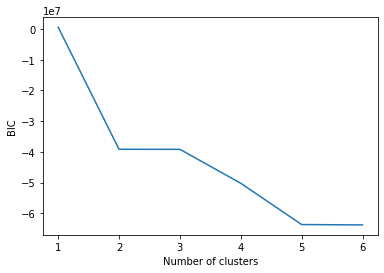

In [28]:
# plot losses
plt.plot(clusters, losses)
plt.ylabel("BIC")
plt.xlabel("Number of clusters")
plt.show()

Based on the analysis on the BIC of the gaussian models (ellbow method),  we perform the clustering with 5 components for the Gaussian Mixture Models.

In [29]:
# run again with k=5
GMM_5 = GaussianMixture(n_components= 5, random_state=4711)
GMM_5.fit(trips)

GaussianMixture(n_components=5, random_state=4711)

We predict the probability of data under each Gaussian in the model

In [30]:
GMM_5.predict_proba(trips)

array([[1.79469086e-41, 0.00000000e+00, 0.00000000e+00, 2.04585496e-08,
        9.99999980e-01],
       [3.10131636e-41, 0.00000000e+00, 0.00000000e+00, 2.89125904e-07,
        9.99999711e-01],
       [5.49927829e-41, 0.00000000e+00, 0.00000000e+00, 4.70913413e-07,
        9.99999529e-01],
       ...,
       [9.63056595e-40, 0.00000000e+00, 0.00000000e+00, 2.67181049e-08,
        9.99999973e-01],
       [2.90325457e-39, 0.00000000e+00, 0.00000000e+00, 3.62966801e-08,
        9.99999964e-01],
       [1.15679537e-42, 0.00000000e+00, 0.00000000e+00, 4.08677470e-04,
        9.99591323e-01]])

The probabilistic cluster assignment shows that most of the trips have a chance of ~ 100% of belonging to one of the clusters. This could be due to many similar trips and a few outliers.

In [31]:
# map cluster to data
trips["cluster"] = GMM_5.predict(trips)

Check size of each cluster

In [32]:
trips.groupby("cluster").size()

cluster
0     13305
1        21
2      6343
3     96631
4    459017
dtype: int64

Compute mean feature values for each cluster

In [33]:
trips.groupby("cluster").mean()

,lat_start,lng_start,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,min_temperature,...,land_use_end_0,land_use_end_1,land_use_end_2,land_use_end_4,land_use_end_5,land_use_end_8,land_use_end_9,land_use_end_11,land_use_end_12,land_use_end_20
cluster,,,,,,,,,,,,,,,,,,,,,
0,51.326476,12.366663,51.324999,12.365052,2.575161,40.717700,6.698766,7.486434,6.331980,18.345189,...,0.059677,0.155054,0.066892,0.294927,0.019391,0.065990,0.177753,0.063059,0.000000,0.097257
1,51.333627,12.358851,51.332196,12.355261,3.123306,7625.047619,0.034024,6.571429,4.952381,21.993651,...,0.000000,0.476190,0.190476,0.047619,0.095238,0.000000,0.000000,0.000000,0.047619,0.142857
2,51.336431,12.370887,51.336046,12.371850,1.930665,96.322245,4.234081,7.554785,7.274949,17.607300,...,0.003153,0.362447,0.166010,0.043197,0.058805,0.004572,0.012770,0.003468,0.123443,0.222135
3,51.335151,12.372127,51.336382,12.372168,1.703825,106.416233,3.992955,6.522431,7.593992,17.129823,...,0.000000,0.378553,0.154888,0.000000,0.057259,0.000000,0.000000,0.000000,0.195827,0.213472
4,51.335632,12.372273,51.335436,12.372278,1.841327,13.989299,7.876415,7.653536,6.750992,15.833657,...,0.000000,0.461260,0.205737,0.000000,0.052120,0.000000,0.000000,0.000000,0.000000,0.280883


In [34]:
trips.groupby("cluster").max()

,lat_start,lng_start,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,min_temperature,...,land_use_end_0,land_use_end_1,land_use_end_2,land_use_end_4,land_use_end_5,land_use_end_8,land_use_end_9,land_use_end_11,land_use_end_12,land_use_end_20
cluster,,,,,,,,,,,,,,,,,,,,,
0,51.405947,12.466099,51.403613,12.466754,12.012614,998.0,24.425117,20,20,37.8,...,1,1,1,1,1,1,1,1,0,1
1,51.375490,12.453182,51.357822,12.454561,6.967286,27376.0,0.090511,20,20,32.7,...,0,1,1,1,1,0,0,0,1,1
2,51.420231,12.466752,51.420231,12.466493,11.968304,2693.0,23.986406,12,20,37.8,...,1,1,1,1,1,1,1,1,1,1
3,51.410853,12.466437,51.409684,12.466478,12.824991,3680.0,24.226610,20,20,37.8,...,0,1,1,0,1,0,0,0,1,1
4,51.413444,12.466551,51.413396,12.468793,9.841793,77.0,24.625702,20,20,37.8,...,0,1,1,0,1,0,0,0,0,1


In [35]:
# function for plotting violin plots to compare clusters regarding different features
def show_cluster_values(columns, cluster_data):
    fig, axs = plt.subplots(int(len(columns) / 2), 2)
    fig.set_size_inches(10, 10)
    sns.set(font_scale = 1.25)
    plots_row = 0
    plots_col = 0
    for col in columns:
        sns.violinplot(
            x=cluster_data["cluster"],
            y=cluster_data[col],
            data=cluster_data,
            palette="magma",
            ax=axs[plots_row][plots_col]
        )
        axs[plots_row][plots_col].set_xlabel("Cluster")
        axs[plots_row][plots_col].set_ylabel("".join(l.capitalize() + " " for l in col.replace("_"," ").split()))
        if plots_col == 1:
            plots_row = plots_row + 1
            plots_col = 0
        else:
            plots_col = 1
    plt.tight_layout()
    plt.savefig("../00_data/processed/GMM_clusters_" + "".join(columns[0]) + ".png")


In [36]:
# function for plotting scatter plots to compare clusters regarding different features
def show_cluster_values_jitter(columns, cluster_data):
    fig, axs = plt.subplots(int(len(columns) / 2), 2)
    fig.set_size_inches(10, 10)
    sns.set(font_scale = 1.25)
    plots_row = 0
    plots_col = 0
    for col in columns:
        sns.stripplot(
            x=cluster_data["cluster"],
            y=cluster_data[col],
            data=cluster_data,
            jitter=True,
            palette="magma",
            ax=axs[plots_row][plots_col]
        )
        axs[plots_row][plots_col].set_xlabel("Cluster")
        axs[plots_row][plots_col].set_ylabel("".join(l.capitalize() + " " for l in col.replace("_"," ").split()))
        if plots_col == 1:
            plots_row = plots_row + 1
            plots_col = 0
        else:
            plots_col = 1
    plt.tight_layout()
    plt.savefig("../00_data/processed/GMM_clusters_" + "".join(columns[0]) + ".png")

#### Location

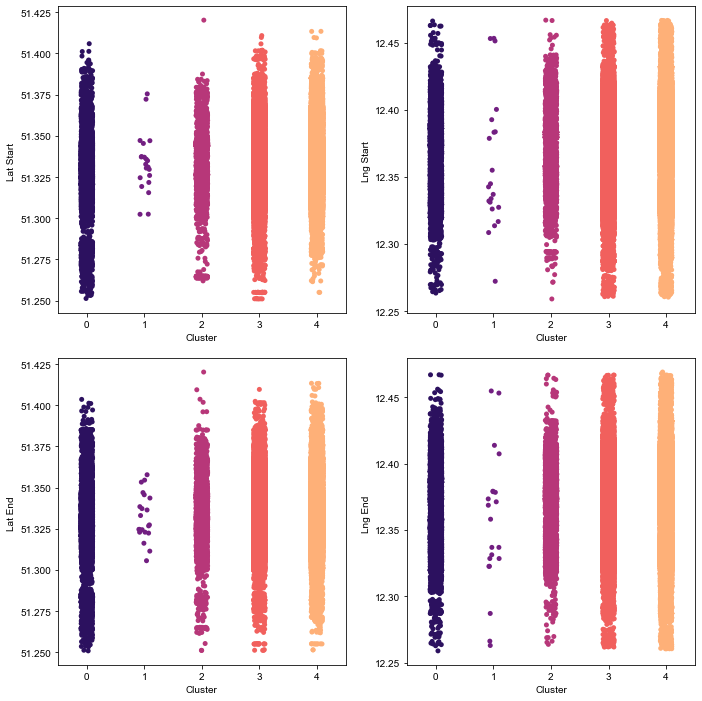

In [37]:
show_cluster_values_jitter(['lat_start', 'lng_start', 'lat_end', 'lng_end'], trips)

- No real differences between start lat and longitude of clusters

#### Temporal

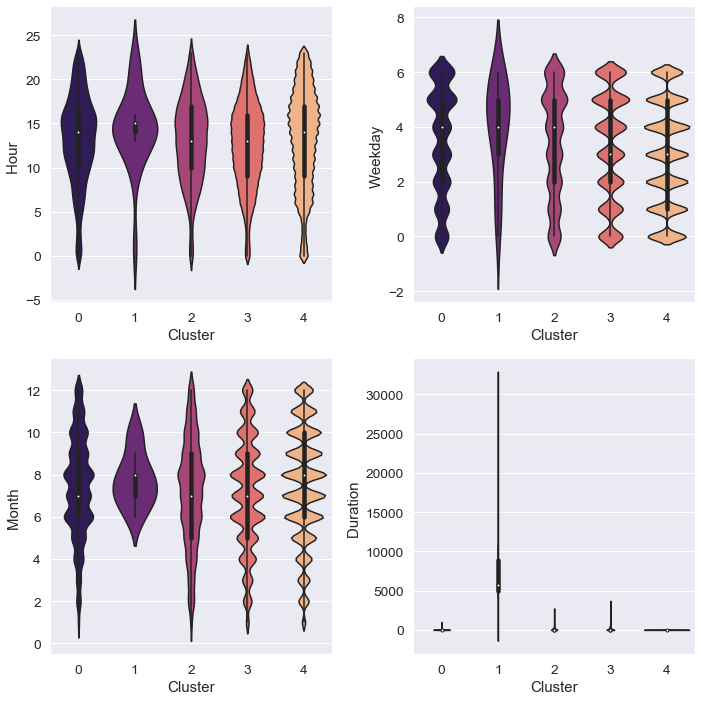

In [38]:
show_cluster_values(['hour', 'weekday', 'month',"duration"], trips)

In [39]:
# Trips per cluster per day
Weekday_Cluster = trips.groupby(["cluster", "weekday"]).size().unstack(fill_value=0).reset_index().rename_axis(None, axis=1)
Weekday_Cluster

Weekday_Cluster.iloc[:, 1:].apply(lambda x: x / x.sum(), axis=1).round(3)

,0,1,2,3,4,5,6
0,0.097,0.107,0.127,0.135,0.133,0.216,0.185
1,0.048,0.095,0.048,0.095,0.238,0.286,0.190
2,0.107,0.108,0.124,0.133,0.147,0.217,0.164
3,0.119,0.122,0.129,0.135,0.155,0.187,0.153
4,0.135,0.145,0.148,0.151,0.162,0.148,0.111


In [40]:
# Trips per cluster per hour
Hour_Cluster = trips.groupby(["cluster", "hour"]).size().unstack(fill_value=0).reset_index().rename_axis(None, axis=1)
Hour_Cluster

Hour_Cluster.iloc[:, 1:].apply(lambda x: x / x.sum(), axis=1).round(3)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.016,0.013,0.010,0.008,0.011,0.020,0.026,0.032,0.033,0.044,...,0.080,0.088,0.086,0.063,0.050,0.041,0.034,0.031,0.026,0.014
1,0.000,0.048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.238,0.286,0.048,0.000,0.048,0.000,0.000,0.095,0.048,0.000
2,0.012,0.008,0.007,0.005,0.007,0.017,0.027,0.041,0.052,0.058,...,0.068,0.088,0.073,0.074,0.053,0.044,0.033,0.026,0.013,0.012
3,0.012,0.010,0.008,0.009,0.015,0.025,0.037,0.042,0.049,0.056,...,0.078,0.081,0.076,0.062,0.047,0.036,0.029,0.020,0.014,0.006
4,0.019,0.015,0.010,0.009,0.011,0.026,0.041,0.044,0.042,0.041,...,0.066,0.072,0.075,0.070,0.061,0.050,0.044,0.039,0.032,0.020


Interpretation:
- Cluster 1 captures trips with very long durations.
- Cluster 0 and 2 displays more trips on the weekend compared to cluster 3 and 4
- Cluster 3 could have captured commuting trips as it declines at the weekend and shows more trips in the morning and evening.


#### Land use

In order to analyze land sue we first need to map it back to its original string values. We create tables and bar charts for both start and end location that show the distribution of land use types.

In [41]:
land_use_dict_rev = {y: x for x, y in land_use_dict.items()}
land_use_dict_rev[0]= "Other"
land_use_dict_rev[1]= "Urban fabric"
land_use_dict_rev[2]= "Industrial, commercial,(..) and private units"
land_use_dict_rev[9]= "Land without use"
land_use_dict_rev[12]= "Railways"
land_use_dict_rev[20]= "Other roads"
land_use_dict_rev["cluster"]= "Cluster"

Start

In [42]:
#create table for land use types for trip start location
land_use_clusters_start = trips.groupby(["cluster", "land_use_start"]).size().unstack(fill_value=0).reset_index().rename_axis(None, axis=1)
land_use_clusters_start.columns = land_use_clusters_start.columns.map(land_use_dict_rev)
land_use_clusters_start.drop(columns=["Other"], inplace=True)
land_use_clusters_start

,Cluster,Urban fabric,"Industrial, commercial,(..) and private units",Sports and leisure facilities,Green urban areas,Pastures,Land without use,Water,Railways,Other roads
0,0,3638,1642,311,441,881,2291,599,0,2749
1,1,12,3,0,0,0,0,0,0,6
2,2,0,0,3484,0,11,43,7,2786,0
3,3,32169,14885,0,28214,0,0,0,0,21363
4,4,201927,93284,0,0,0,0,0,18939,144867


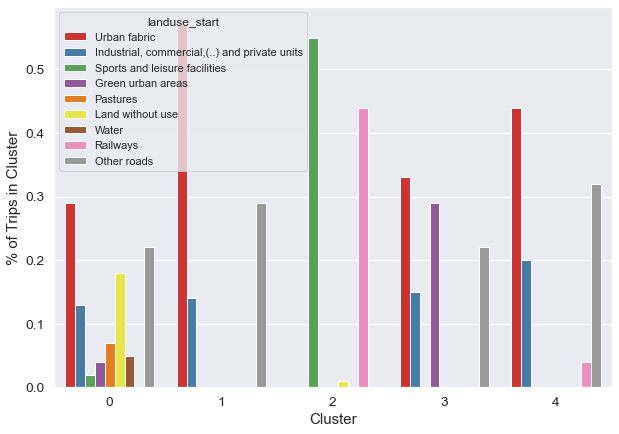

In [43]:
land_use_clusters_start_perc = land_use_clusters_start.iloc[:, 1:].apply(lambda x: x / x.sum(), axis=1).round(2)
land_use_clusters_start_perc['Cluster'] = land_use_clusters_start['Cluster']

df_melted = land_use_clusters_start_perc.melt("Cluster",var_name="landuse_start",value_name="% of Trips in Cluster")

f, ax = plt.subplots(figsize = (10,7))
sns.set(font_scale = 1)
ax = sns.barplot(x="Cluster", y="% of Trips in Cluster", hue="landuse_start", data=df_melted, palette="Set1")
f.savefig("../00_data/processed/GMM_landuse_start.png")

End

In [44]:
#create table for land use types for trip end location
land_use_clusters_end = trips.groupby(["cluster", "land_use_end"]).size().unstack(fill_value=0).reset_index().rename_axis(None, axis=1)
land_use_clusters_end.columns = land_use_clusters_end.columns.map(land_use_dict_rev)
land_use_clusters_end.drop(columns=["Other"], inplace=True)
land_use_clusters_end

,Cluster,Urban fabric,"Industrial, commercial,(..) and private units",Sports and leisure facilities,Green urban areas,Pastures,Land without use,Water,Railways,Other roads
0,0,2063,890,3924,258,878,2365,839,0,1294
1,1,10,4,1,2,0,0,0,1,3
2,2,2299,1053,274,373,29,81,22,783,1409
3,3,36580,14967,0,5533,0,0,0,18923,20628
4,4,211726,94437,0,23924,0,0,0,0,128930


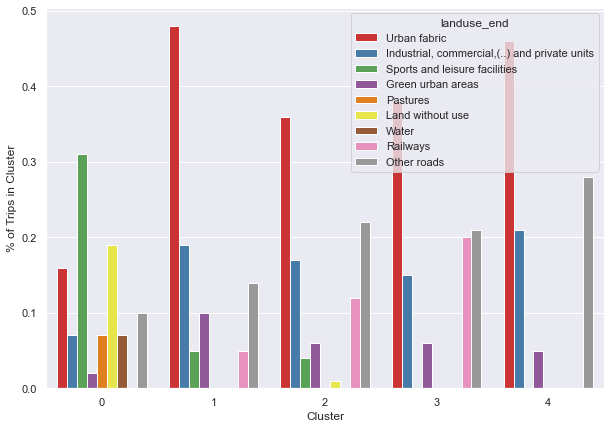

In [45]:
land_use_clusters_end_perc = land_use_clusters_end.iloc[:, 1:].apply(lambda x: x / x.sum(), axis=1).round(2)
land_use_clusters_end_perc['Cluster'] = land_use_clusters_end['Cluster']

df_melted = land_use_clusters_end_perc.melt("Cluster",var_name="landuse_end",value_name="% of Trips in Cluster")

f, ax = plt.subplots(figsize = (10,7))
sns.set(font_scale = 1)
ax = sns.barplot(x="Cluster", y="% of Trips in Cluster", hue="landuse_end", data=df_melted, palette="Set1")
f.savefig("../00_data/processed/GMM_landuse_end.png")

#### Trip Info and Land use (continous)

We also take a look at some trip info about speed and distance. Land use is also once again included here. Although it is plotted using one variable the clustering is done using one-hot-encoding since there is no ordering in the land use types.

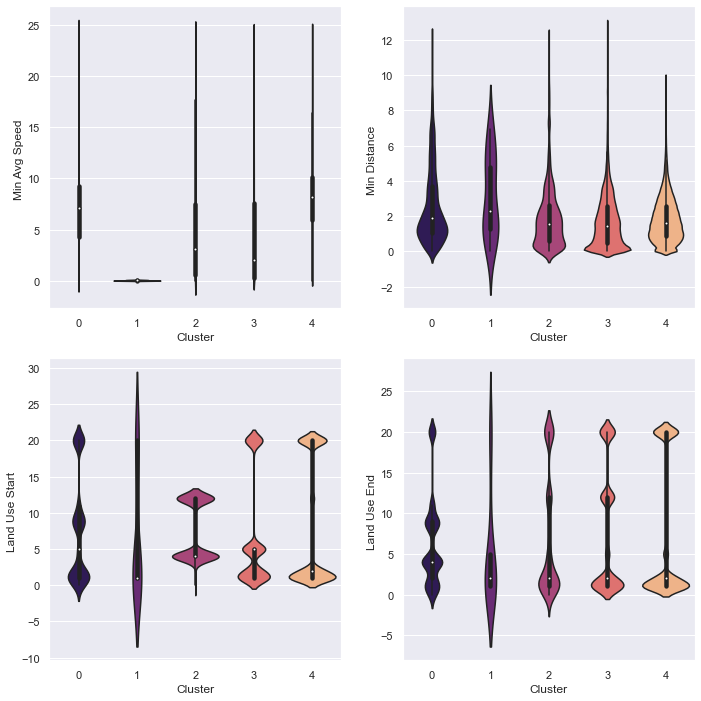

In [46]:
show_cluster_values(["min_avg_speed", "min_distance", "land_use_start", "land_use_end"],trips)

- No interesting patterns can be found looking at the speed, distance or land use type.
- The most common landuse observed is '1: Discontinuous dense urban fabric' and '20: Other roads and associated land'. Cluster 3 also shows many trips ending at land use '12: Railways and associated land' which probably captures the main train station of Leipzig.

In [47]:
# Trips per cluster per start land use type
landUseStart_Cluster = trips.groupby(["cluster", "land_use_start"]).size().unstack(fill_value=0).reset_index().rename_axis(None, axis=1)
landUseStart_Cluster

,cluster,0,1,2,4,5,8,9,11,12,20
0,0,753,3638,1642,311,441,881,2291,599,0,2749
1,1,0,12,3,0,0,0,0,0,0,6
2,2,12,0,0,3484,0,11,43,7,2786,0
3,3,0,32169,14885,0,28214,0,0,0,0,21363
4,4,0,201927,93284,0,0,0,0,0,18939,144867


In [48]:
# Percentage of trips per cluster per land use type
landUseStart_Cluster.iloc[:, 1:].apply(lambda x: x / x.sum(), axis=1).round(3)

,0,1,2,4,5,8,9,11,12,20
0,0.057,0.273,0.123,0.023,0.033,0.066,0.172,0.045,0.000,0.207
1,0.000,0.571,0.143,0.000,0.000,0.000,0.000,0.000,0.000,0.286
2,0.002,0.000,0.000,0.549,0.000,0.002,0.007,0.001,0.439,0.000
3,0.000,0.333,0.154,0.000,0.292,0.000,0.000,0.000,0.000,0.221
4,0.000,0.440,0.203,0.000,0.000,0.000,0.000,0.000,0.041,0.316


In [49]:
# Trips per cluster per end land use type
landUseEnd_Cluster = trips.groupby(["cluster", "land_use_end"]).size().unstack(fill_value=0).reset_index().rename_axis(None, axis=1)
landUseEnd_Cluster

,cluster,0,1,2,4,5,8,9,11,12,20
0,0,794,2063,890,3924,258,878,2365,839,0,1294
1,1,0,10,4,1,2,0,0,0,1,3
2,2,20,2299,1053,274,373,29,81,22,783,1409
3,3,0,36580,14967,0,5533,0,0,0,18923,20628
4,4,0,211726,94437,0,23924,0,0,0,0,128930


In [50]:
# Percentage of trips per cluster per land use type
landUseEnd_Cluster.iloc[:, 1:].apply(lambda x: x / x.sum(), axis=1).round(3)

,0,1,2,4,5,8,9,11,12,20
0,0.060,0.155,0.067,0.295,0.019,0.066,0.178,0.063,0.000,0.097
1,0.000,0.476,0.190,0.048,0.095,0.000,0.000,0.000,0.048,0.143
2,0.003,0.362,0.166,0.043,0.059,0.005,0.013,0.003,0.123,0.222
3,0.000,0.379,0.155,0.000,0.057,0.000,0.000,0.000,0.196,0.213
4,0.000,0.461,0.206,0.000,0.052,0.000,0.000,0.000,0.000,0.281


Land use type: dictionary:

In [51]:
{y: x for x, y in land_use_dict.items()}

{1: 'Discontinuous dense urban fabric (S.L. : 50% -  80%)',
 2: 'Industrial, commercial, public, military and private units',
 3: 'Continuous urban fabric (S.L. : > 80%)',
 4: 'Sports and leisure facilities',
 5: 'Green urban areas',
 6: 'Discontinuous medium density urban fabric (S.L. : 30% - 50%)',
 7: 'Arable land (annual crops)',
 8: 'Pastures',
 9: 'Land without current use',
 10: 'Forests',
 11: 'Water',
 12: 'Railways and associated land',
 13: 'Discontinuous low density urban fabric (S.L. : 10% - 30%)',
 14: 'Mineral extraction and dump sites',
 15: 'Isolated structures',
 16: 'Herbaceous vegetation associations (natural grassland, moors...)',
 17: 'Discontinuous very low density urban fabric (S.L. : < 10%)',
 18: 'Construction sites',
 19: 'Fast transit roads and associated land',
 20: 'Other roads and associated land',
 21: 'Open spaces with little or no vegetation (beaches, dunes, bare rocks, glaciers)',
 22: 'Wetlands'}

#### Weather

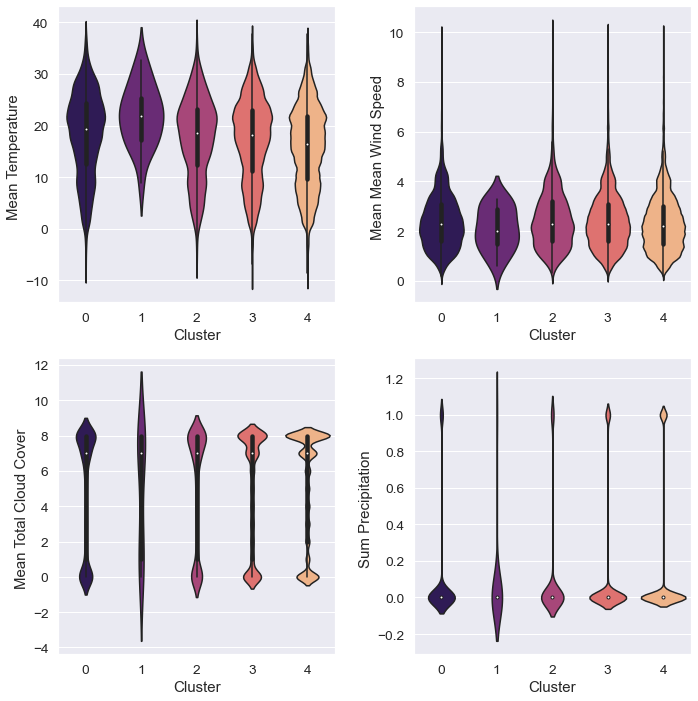

In [52]:
show_cluster_values(["mean_temperature", 'mean_mean_wind_speed', 'mean_total_cloud_cover', "sum_precipitation"], trips)
# All features

- no variance of the clusters on the weather features is observable.

#### POIs

Lastly, we plot the POUS for the trip start and end location.

In [53]:
#we create another function to allow for more plots next to each other
def show_cluster_values_2(columns, cluster_data):
    fig, axs = plt.subplots(2, 5)
    fig.set_size_inches(18, 8)
    sns.set(font_scale = 1.25)
    plots_row = 0
    plots_col = 0
    for col in columns:
        sns.violinplot(
            x=cluster_data["cluster"],
            y=cluster_data[col],
            data=cluster_data,
            palette="magma",
            ax=axs[plots_row][plots_col]
        )
        axs[plots_row][plots_col].set_xlabel("Cluster")
        axs[plots_row][plots_col].set_ylabel("".join(l.capitalize() + " " for l in col.replace("_"," ").split()))
        if plots_col == 4:
            plots_row = plots_row + 1
            plots_col = 0
        else:
            plots_col = plots_col +1
    plt.tight_layout()
    plt.savefig("../00_data/processed/GMM_clusters_" + "".join(columns[0]) + ".png")

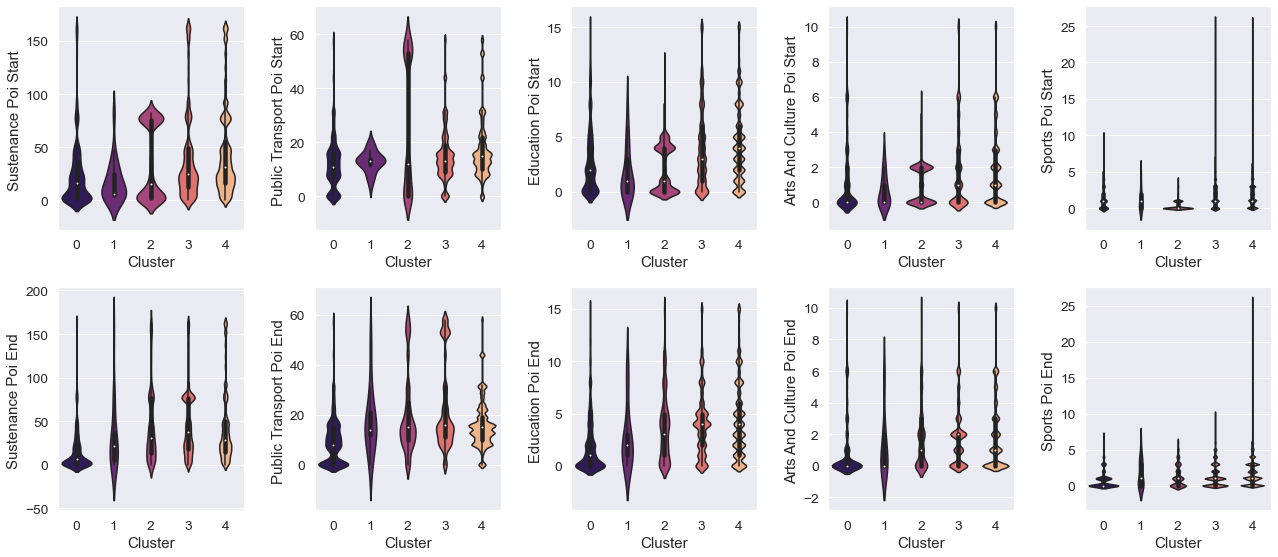

In [54]:
show_cluster_values_2(
    ['sustenance_poi_start',
     'public_transport_poi_start', 'education_poi_start',
     'arts_and_culture_poi_start', 'sports_poi_start', 'sustenance_poi_end',
     'public_transport_poi_end', 'education_poi_end',
     'arts_and_culture_poi_end', 'sports_poi_end'], trips
)

Interpretation:
- Cluster 3 has many trips that end a high density of public transport pois, sustenance poi and education pois. This could be as these trips end in the center of the city where the density of pois is higher than average.
- Despite this no apparent differences can be observed.

## Gaussian Mixture Models partial clustering

In this section we cluster using only a subset of the features and then take a look at all features per cluster. Thus, we hope to identify how features interact and compliment each other. Because we do not discuss this part in the paper, we have not analyzed and interpreted the plots.

### Spatial Data (lat,lon)

First we cluster based on the latitude and longitude of start and end of the trips.

--- 20.164342880249023 seconds ---


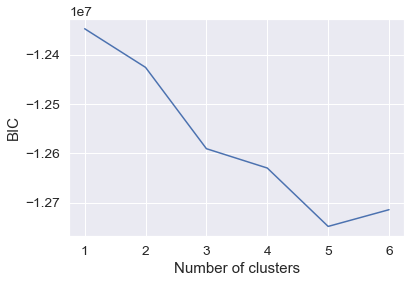

In [56]:
features_spatial = ['lat_start', 'lng_start', 'lat_end', 'lng_end']
X_spatial = trips[features_spatial]

# defining the maximum quantity of centers
k_max = 6

clusters = []
losses = []

# train each model and save losses
for k in range(k_max):
    model = GaussianMixture(n_components= k + 1, random_state=4711)
    model.fit(X_spatial)
    clusters.append(k + 1)
    losses.append(model.bic(X_spatial))

# plot losses
plt.plot(clusters, losses)
plt.ylabel("BIC")
plt.xlabel("Number of clusters")
plt.show()

In [57]:
# run again with k=5
GMM_5 = GaussianMixture(n_components= 5, random_state=4711)
GMM_5.fit(X_spatial)
X_spatial["cluster"] = GMM_5.predict(X_spatial)

# Merge temporal information back into clustered data
trips_temp = trips[['hour' , "weekday" , "month", ]]
X_spatial = X_spatial.join(trips_temp)

/var/folders/mc/lvrtd_g53mg1hjjvx1yh3fmc0000gn/T/ipykernel_44045/2806295874.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_spatial["cluster"] = GMM_5.predict(X_spatial)


,lat_start,lng_start,lat_end,lng_end,cluster,hour,weekday,month
0,51.332653,12.367146,51.338884,12.332661,1,20,6,1
1,51.338741,12.332891,51.322920,12.336262,1,8,0,1
2,51.322920,12.336262,51.326782,12.339472,1,9,0,1
3,51.327149,12.339131,51.326231,12.368130,2,12,0,1
4,51.326178,12.368146,51.336542,12.374882,3,13,0,1


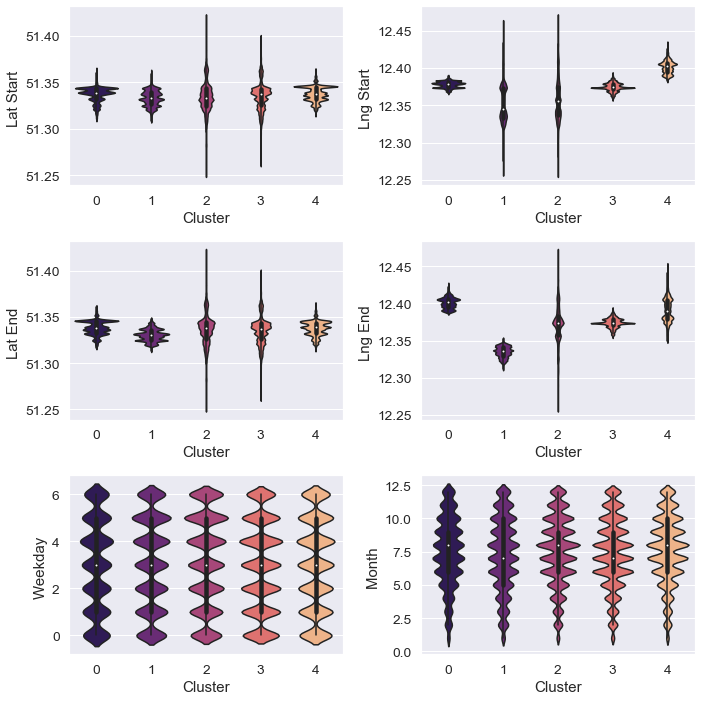

In [58]:
# 3 Visualize
show_cluster_values(
    ['lat_start', 'lng_start', 'lat_end', 'lng_end' , "weekday" , "month" ], X_spatial
)


### Movement features

--- 50.66178488731384 seconds ---


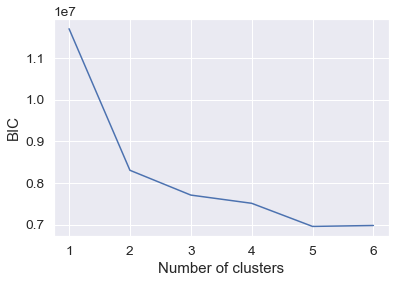

In [59]:
features_movement = ['min_distance','duration', 'min_avg_speed']
X_movement = trips[features_movement]

# defining the maximum quantity of centers
k_max = 6

clusters = []
losses = []

# train each model and save losses
for k in range(k_max):
    model = GaussianMixture(n_components= k + 1, random_state=4711)
    model.fit(X_movement)
    clusters.append(k + 1)
    losses.append(model.bic(X_movement))

# plot losses
plt.plot(clusters, losses)
plt.ylabel("BIC")
plt.xlabel("Number of clusters")
plt.show()

In [60]:
# run again with k=2
GMM = GaussianMixture(n_components= 2, random_state=4711)
GMM.fit(X_movement)
X_movement["cluster"] = GMM.predict(X_movement )

# Merge temporal information back into clustered data
trips_temp = trips[['hour' , "weekday" , "month"]]
X_movement = X_movement.join(trips_temp)

/var/folders/mc/lvrtd_g53mg1hjjvx1yh3fmc0000gn/T/ipykernel_44045/2837421462.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_movement["cluster"] = GMM_5.predict(X_movement )


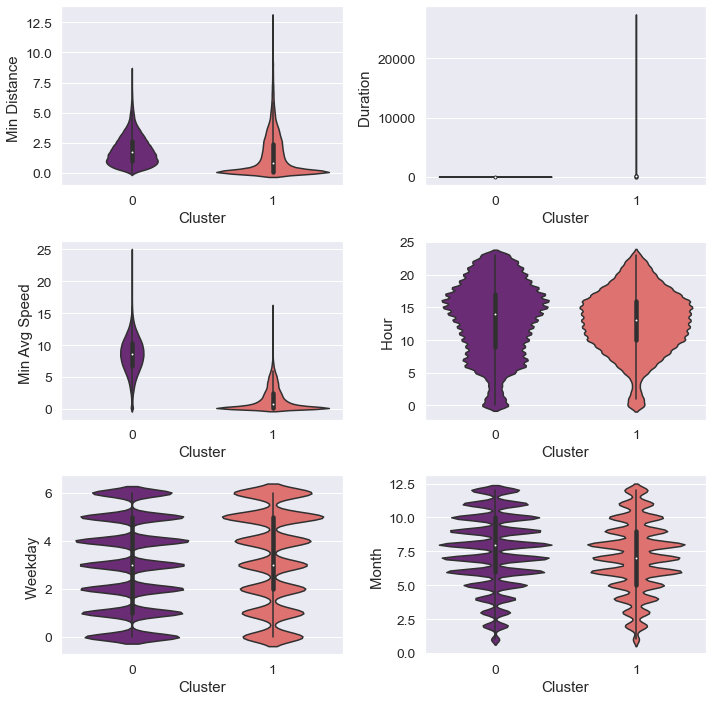

In [61]:
# 3 Visualize
show_cluster_values(['min_distance','duration', 'min_avg_speed','hour' , "weekday" , "month" ], X_movement)

### Weather features

Now we cluster on the weather features.

--- 16.41562032699585 seconds ---


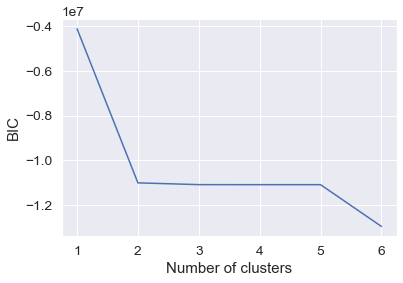

In [63]:
# 1 finding the right amount of clusters

features_weather = ['min_temperature', 'max_temperature', 'mean_temperature',
                     'mean_mean_wind_speed', 'mean_total_cloud_cover', 'sum_precipitation']
X_weather = trips[features_weather]

# defining the maximum quantity of centers
k_max = 6

clusters = []
losses = []

start_time = time.time()
# train each model and save losses
for k in range(k_max):
    model = GaussianMixture(n_components= k + 1, random_state=4711)
    model.fit(X_weather)
    clusters.append(k + 1)
    losses.append(model.bic(X_weather))

print("--- %s seconds ---" % (time.time() - start_time))

# plot losses
plt.plot(clusters, losses)
plt.ylabel("BIC")
plt.xlabel("Number of clusters")
plt.show()

In [64]:
# run again with k=2
GMM = GaussianMixture(n_components= 2, random_state=4711)
GMM.fit(X_weather)
X_weather["cluster"] = GMM.predict(X_weather)

# Merge temporal information back into clustered data
trips_temp = trips[['hour' , "weekday" , "month",  'min_distance',
                    'duration', 'min_avg_speed']]
X_weather = X_weather.join(trips_temp)

/var/folders/mc/lvrtd_g53mg1hjjvx1yh3fmc0000gn/T/ipykernel_44045/1575481003.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_weather["cluster"] = GMM_5.predict(X_weather )


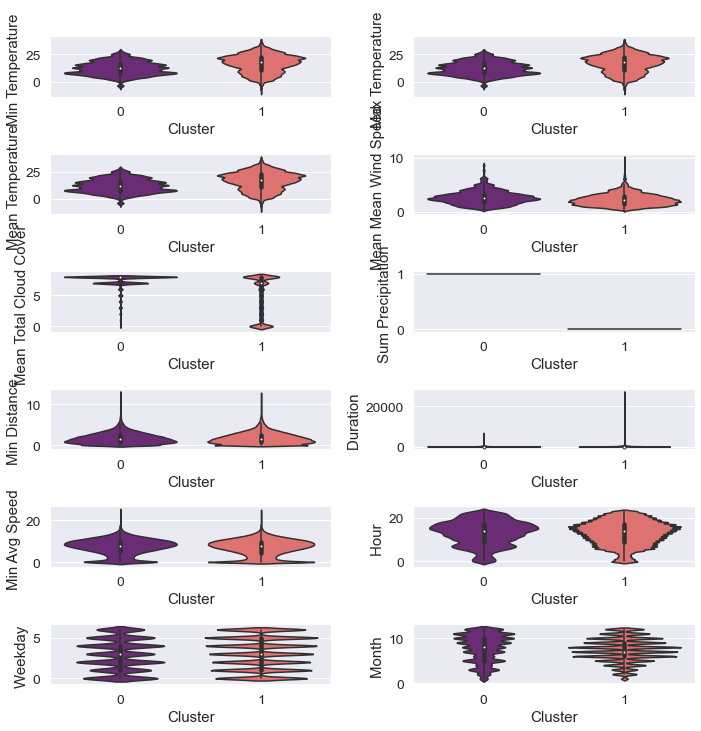

In [65]:
# 3 Visualize
show_cluster_values(
    ['min_temperature', 'max_temperature', 'mean_temperature',
     'mean_mean_wind_speed', 'mean_total_cloud_cover', 'sum_precipitation', 'min_distance','duration', 'min_avg_speed','hour' , "weekday" , "month" ], X_weather
)

### POI

--- 13.433544158935547 seconds ---


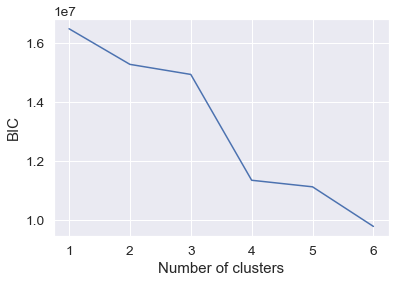

In [66]:
features_poi = ['sustenance_poi_start',
                    'public_transport_poi_start', 'education_poi_start',
                    'arts_and_culture_poi_start', 'sports_poi_start']
X_poi = trips[features_poi]

# defining the maximum quantity of centers
k_max = 6

clusters = []
losses = []

# train each model and save losses
for k in range(k_max):
    model = GaussianMixture(n_components= k + 1, random_state=4711)
    model.fit(X_poi)
    clusters.append(k + 1)
    losses.append(model.bic(X_poi))

# plot losses
plt.plot(clusters, losses)
plt.ylabel("BIC")
plt.xlabel("Number of clusters")
plt.show()

In [67]:
# run again with k=4
GMM = GaussianMixture(n_components= 4, random_state=4711)
GMM.fit(X_poi)
X_poi["cluster"] = GMM.predict(X_poi)

# Merge temporal information back into clustered data
trips_temp = trips[['hour' , "weekday" , "month", 'sustenance_poi_end',
                    'public_transport_poi_end', 'education_poi_end',
                    'arts_and_culture_poi_end', 'sports_poi_end']]
X_poi = X_poi.join(trips_temp)

/var/folders/mc/lvrtd_g53mg1hjjvx1yh3fmc0000gn/T/ipykernel_44045/3911956497.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_poi["cluster"] = GMM_5.predict(X_poi )


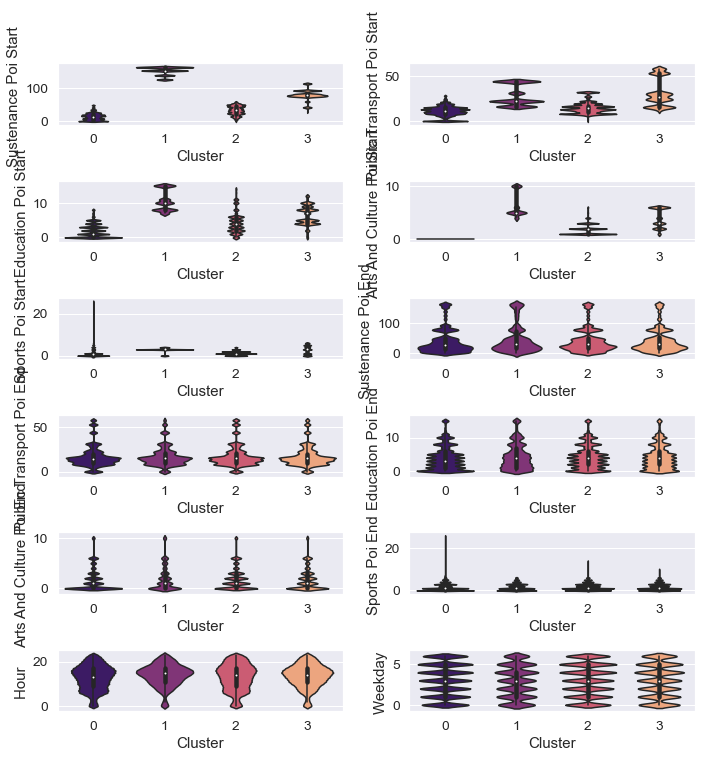

In [68]:
# 3 Visualize
show_cluster_values(
    ['sustenance_poi_start',
     'public_transport_poi_start', 'education_poi_start',
     'arts_and_culture_poi_start', 'sports_poi_start', 'sustenance_poi_end',
     'public_transport_poi_end', 'education_poi_end',
     'arts_and_culture_poi_end', 'sports_poi_end' ,'hour' , "weekday" ], X_poi
)